# Burn mapping validation
This script shows the workflow of roc (Receiver operating characteristic) analysis of burn mapping with fire perimeters polygons

## import the required modules 
import the validationtoolbox for validation

In [2]:
import xarray as xr
import numpy as np
import validationtoolbox as val
import matplotlib.pyplot as plt
%matplotlib inline

## load the severity map
load a saved netcdf file for the severity for central plateau in 2016 for validation 

the severity mapping steps can also be inserted here 

In [3]:
sev = xr.open_dataset('/g/data/xc0/project/Burn_Mapping/TestSites/BurnMapping_Sumac_2016.nc')

## convert the data to a burned mask for validation
use the `burnpixel_masking` from the validation toolbox

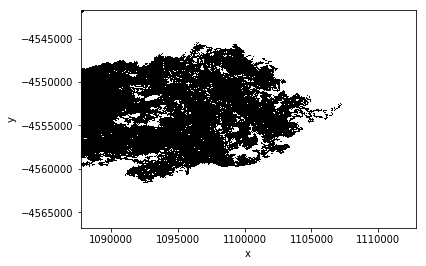

In [4]:
Burnpixel = val.burnpixel_masking(sev,'Medium') # mask the burnt area with "Medium" burnt area
Burnpixel.plot.imshow(cmap='binary',add_colorbar=False)

## seperate the burned area into forest burned and none forest burned area
use the `treecover_masking` tool to generate the tree cover mask for the given region.

Required inputs:

    "year" should be before the bushfire, 
    "data" the Burnpixel with x,y
    "prctg" the treecover fraction used for forest mapping, default is 60
Outputs:

    forest mask, 1 for forest 0 for none forest
    none-forest mask, 1 for none-forest mask 0 for forest
    

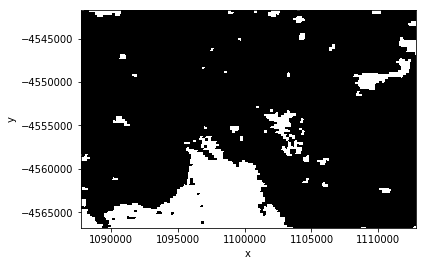

In [6]:
#forest mask has to be derived from the tree cover data before fire occured
mask=val.treecover_masking(year=2015,data=Burnpixel,prctg=60) 
mask.ForestMask.plot.imshow(cmap='binary',add_colorbar=False)

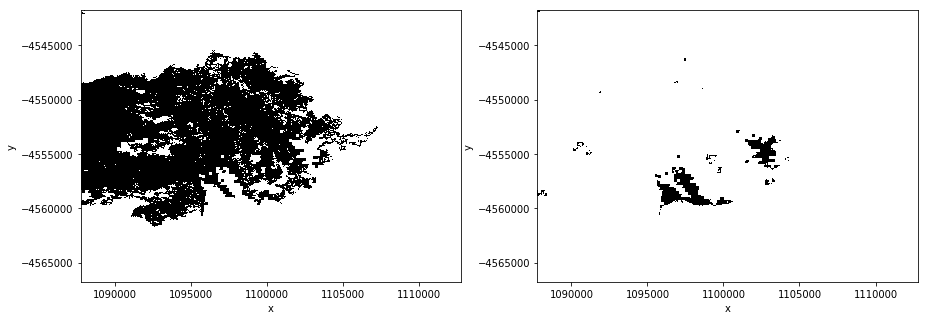

In [9]:
ForestBurned = Burnpixel*mask.ForestMask # burned pixel found in the forest area
NoneForestBurned = Burnpixel*mask.NoneForestMask # burned pixel found in the non-forest area
fig,axes=plt.subplots(ncols=2,figsize=[15,5])
ForestBurned.plot.imshow(ax=axes[0],cmap='binary',add_colorbar=False)
NoneForestBurned.plot.imshow(ax=axes[1],cmap='binary',add_colorbar=False)

## generate validation mask for roc analysis
use `CreateValidatedBurnMask` for creating corresponding validation mask from the shapefiles of fire perimeters polygons

required inputs:

    BurnPixel: burned pixel 
    State: abbrev of the state name 
    Validation_period: start and end
    
output mask includes the mask at each time step, sum up if a single mask required


In [11]:
ValidationMask=val.CreateValidatedBurnMask(Burnpixel,State='TAS', Validation_period=("2016-01-01","2016-12-31"))
ValidationMask = ValidationMask.sum('time') #create one mask with all the burned area

I am densified (external_values, 465 elements)


## Validation for forest and non-forest burnt
If use `validationtoolbox.validate`, forest and non-forest will be combined and validate together
If use `validationtoolbox.validate_forest_grass`, forest and non-forest will be combined and validate separately but shown in the same figure

The following example shows the validation for the corrected mapped forest burnt in darker green and non-forest burnt in lighter green

The false positive and truth positive rate for forest burnt area: 0.009, 0.906
The false positive and truth positive rate for non-forest burnt area: 0.000, 0.856


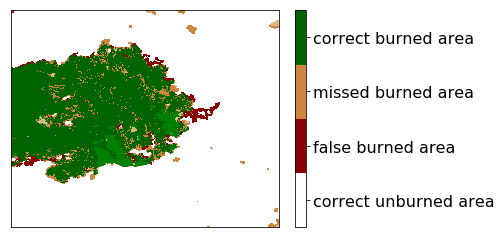

In [12]:
a,b = val.validate_forest_grass(Test_Array = Burnpixel, Validated_Array = ValidationMask,Mask = mask, plot=True)
print('The false positive and truth positive rate for forest burnt area: %.3f, %.3f' %(a[0],a[1]))
print('The false positive and truth positive rate for non-forest burnt area: %.3f, %.3f' %(b[0],b[1]))